## Prediction the Function F(x1,x2,x3,x4,x5,x6) = (x1+x2+x3+x4)^2 - (x3+x4+x5+x6)^2

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set()

Using TensorFlow backend.


In [4]:
np.random.seed(seed=100)
SAMPLES = 1500
EPOCHS = 500

In [5]:
def F(x1, x2, x3, x4):
    return ((x1 + x2)**2.0 + (x2 + x3) ** 2.0) ** 2.0 - ((x2 + x3)**2.0 + (x3 + x4) ** 2.0) ** 2.0

## Data, Range = [0,1]

In [45]:
data = pd.DataFrame(np.random.rand(SAMPLES,4), columns=['x1', 'x2', 'x3', 'x4'])
data['F'] = F(data['x1'],data['x2'],data['x3'],data['x4'])
X = data.drop(['F'], axis = 1)
Y = data['F']

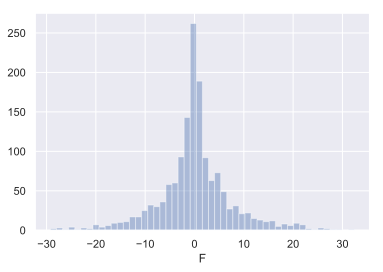

In [8]:
_ = sns.distplot(data['F'], kde = False, bins = 50)

In [70]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def train_model(model, X, Y):
    history = model.fit(X, Y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
    return history

def show_history(history):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['log_loss_1'] = np.log(history_df['loss'] + 1)
    sns.lineplot(data = history_df, y='log_loss_1', x='epoch')
    plt.gca().set_ylim(bottom=0)
    
def show_predictions(model, X, Y):
    predicted = model.predict(X).flatten()
    expected = Y
    print("MSE = " + str(((Y-predicted)**2.0).mean()))
    plt.scatter(expected, predicted, alpha=.33, color='yellowgreen')
    plt.xlabel('Real Values [F]')
    plt.ylabel('Predictions [F]')
    plt.axis('equal')
    plt.axis('square')
    #plt.xlim([0,plt.xlim()[1]])
    plt.ylim([min(Y) - 1.0,max(Y) + 1.0])
    _ = plt.plot([-100, 100], [-100, 100])

In [26]:
def build_halved_model():
    input1 = Input(shape=(3,))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    hidden1_3 = Dense(4, activation='relu')(hidden1_2)
    out1 = Dense(1)(hidden1_3)
    
    input2 = Input(shape=(3,))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    hidden2_3 = Dense(4, activation='relu')(hidden2_2)
    out2 = Dense(1)(hidden2_3)
    
    merge = concatenate([out1, out2], name='merge')
    hidden = Dense(4, activation='relu')(merge)
    hidden_x = Dense(4)(hidden)
    output = Dense(1)(hidden_x)
    
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('merge').output)
    
    return model, intermediate_layer_model
halved_model, intermediate_layer_model = build_halved_model()
halved_X = [X[['x1', 'x2','x3']], X[['x2', 'x3', 'x4']]]
history = train_model(halved_model, halved_X, Y)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

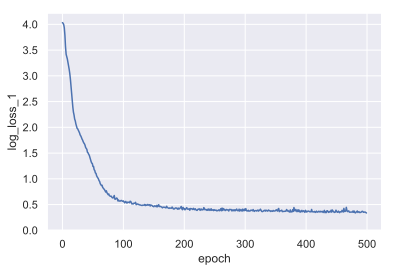

In [27]:
show_history(history)

MSE = 0.4967813861093294


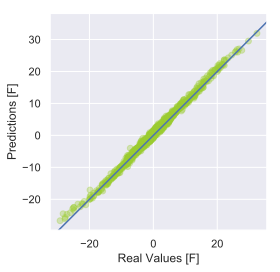

In [28]:
show_predictions(halved_model, halved_X, Y)

In [30]:
points_range = np.linspace(0,1,5)
sample_points = []
for x1 in points_range:
    for x2 in points_range:
        for x3 in points_range:
            sample_points.append([x1,x2,x3])
data_frame = pd.DataFrame(columns=['(x1+x2)^2+(x2+x3)^2', 'NN1', 'NN2'])
for point in sample_points:
    output1, output2 = intermediate_layer_model.predict([[point], [point]])[0]
    expected = (point[0] + point[1])**2.0 + (point[1] + point[2])**2.0
    data_frame = data_frame.append({'(x1+x2)^2+(x2+x3)^2' : expected,
                                    '(x2+x3)^2+(x3+x4)^2' : expected,
                                    'NN1'             : output1,
                                    'NN2'             : output2} , ignore_index=True)

data_frame = data_frame.sort_values(by=['(x1+x2)^2+(x2+x3)^2'])
data_frame.head()

,(x1+x2)^2+(x2+x3)^2,NN1,NN2,(x2+x3)^2+(x3+x4)^2
0,0.0000,2.954266,-7.149853,0.0000
25,0.0625,2.988510,-6.973696,0.0625
1,0.0625,2.730866,-7.027239,0.0625
5,0.1250,2.909358,-6.632451,0.1250
26,0.1250,2.774728,-6.856438,0.1250


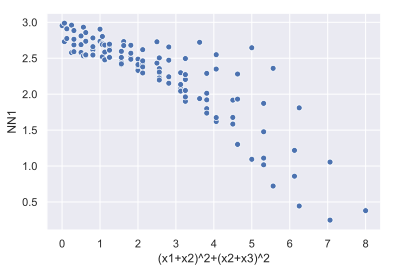

In [31]:
_ = sns.scatterplot(x="(x1+x2)^2+(x2+x3)^2", y="NN1", data=data_frame)

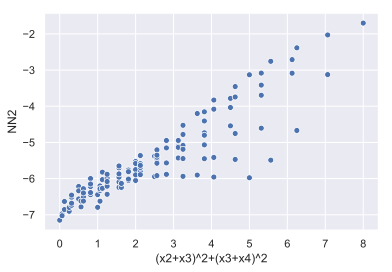

In [32]:
_ = sns.scatterplot(x="(x2+x3)^2+(x3+x4)^2", y="NN2", data=data_frame)

In [72]:
def build_halved_model2():
    input1 = Input(shape=(2,))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    out1 = Dense(1)(hidden1_2)
    
    input2 = Input(shape=(2,))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    out2 = Dense(1)(hidden2_2)
    
    merge = concatenate([out1, out2], name='merge')
    hidden = Dense(4, activation='relu')(merge)
    hidden_x = Dense(4)(hidden)
    output = Dense(1)(hidden_x)
    
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('merge').output)
    
    return model, intermediate_layer_model
halved_model2, intermediate_layer_model2 = build_halved_model2()
halved_halved_X = [X[['x1', 'x2']], X[['x2', 'x3']]]
halved_halved_Y = np.array(list(map(lambda a: a[0], intermediate_layer_model.predict(halved_X))))
history2 = train_model(halved_model2, halved_halved_X, halved_halved_Y)
#len(halved_halved_Y)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

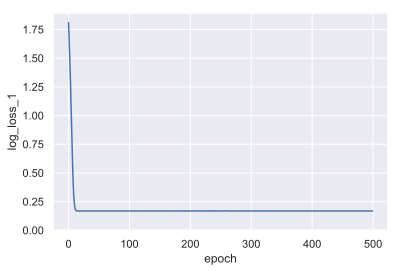

In [73]:
show_history(history2)

MSE = 0.18322136


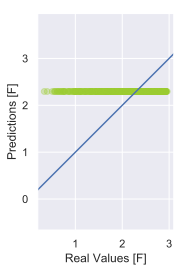

In [74]:
show_predictions(halved_model2, halved_halved_X, halved_halved_Y)